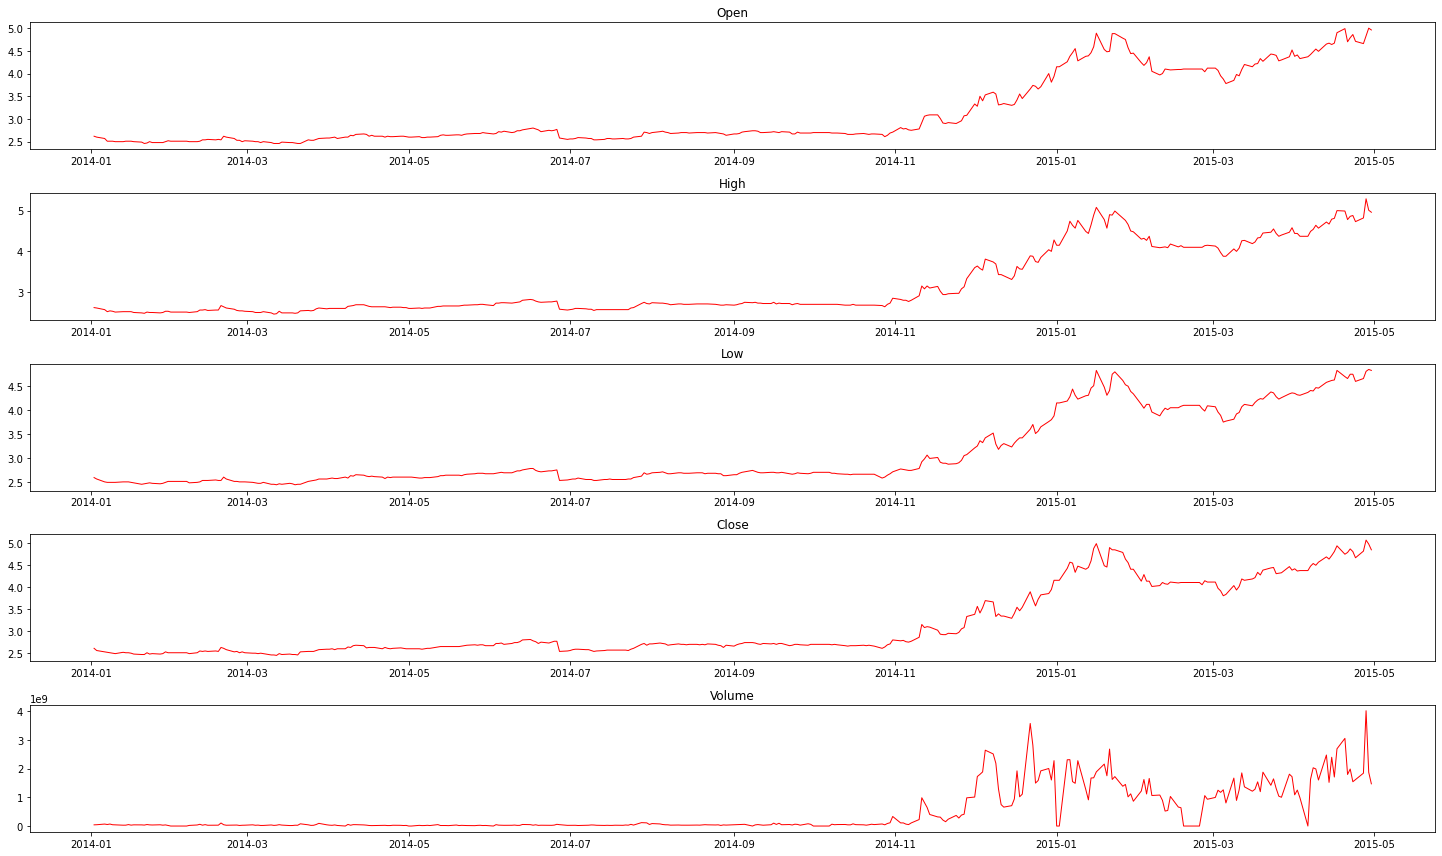

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.stats.stattools import durbin_watson
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
# step1：导入数据
df = pd.read_csv(r'D:/ChinaBank.csv', parse_dates=['Date'], index_col='Date')
df.drop('Unnamed: 0',axis=1, inplace=True)
df = df.dropna()
# 画出5个时间序列的图像
fig, axes = plt.subplots(nrows=5, ncols=1,figsize=(20,12))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    ax.set_title(df.columns[i])
plt.tight_layout()

In [2]:
# step2：检验不同序列之间存在互相影响
maxlag=12
test='ssr_chi2test'
variables=df.columns
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df, variables = df.columns)

,Open_x,High_x,Low_x,Close_x,Volume_x
Open_y,1.0000,0.0000,0.000,0.0,0.0000
High_y,0.0000,1.0000,0.000,0.0,0.0000
Low_y,0.0005,0.0000,1.000,0.0,0.0013
Close_y,0.0000,0.0007,0.001,1.0,0.0010
Volume_y,0.0000,0.0000,0.000,0.0,1.0000


In [3]:
# step3：ADF测试，检验单个变量是否平稳
def adfuller_test(series, signif=0.05, name='', verbose=False):
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'        Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")
for name, column in df.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

        Augmented Dickey-Fuller Test on "Open" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = 0.2874
 No. Lags Chosen       = 14
 Critical value 1%     = -3.45
 Critical value 5%     = -2.87
 Critical value 10%    = -2.571
 => P-Value = 0.9768. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


        Augmented Dickey-Fuller Test on "High" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = 0.0789
 No. Lags Chosen       = 14
 Critical value 1%     = -3.45
 Critical value 5%     = -2.87
 Critical value 10%    = -2.571
 => P-Value = 0.9646. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


        Augmented Dickey-Fuller Test on "Low" 
    -----------------------------------------------
 Null Hypothesis: Data has 

In [4]:
# step4: 协整检验，检验多变量平稳性
def cointegration_test(df, alpha=0.05): 
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Open   ::  170.4     > 60.0627   =>   True
High   ::  94.39     > 40.1749   =>   True
Low    ::  31.15     > 24.2761   =>   True
Close  ::  14.19     > 12.3212   =>   True
Volume ::  2.31      > 4.1296    =>   False


In [5]:
# step5：划分训练集和测试集
df_train, df_test = df[0:62], df[62:84]

In [6]:
# step6：使用VAR之间，先差分处理使单个变量变得平稳
df_differenced = df_train.diff().dropna()
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

        Augmented Dickey-Fuller Test on "Open" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.5788
 No. Lags Chosen       = 0
 Critical value 1%     = -3.544
 Critical value 5%     = -2.911
 Critical value 10%    = -2.593
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


        Augmented Dickey-Fuller Test on "High" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.4005
 No. Lags Chosen       = 0
 Critical value 1%     = -3.544
 Critical value 5%     = -2.911
 Critical value 10%    = -2.593
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


        Augmented Dickey-Fuller Test on "Low" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level

In [7]:
# step7：选择模型阶数并训练，选取阶数
model = VAR(df_differenced)
for i in [1,2,3,4,5,6,7,8,9,10,11]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  -1.4705504528923257
BIC :  -0.42337817178127546
FPE :  0.230570876036711
HQIC:  -1.0609438064633732 

Lag Order = 2
AIC :  -1.6895709563502384
BIC :  0.24711649135848335
FPE :  0.1887170302459583
HQIC:  -0.9335666133363851 

Lag Order = 3
AIC :  -1.603198256125106
BIC :  1.2387921032492653
FPE :  0.21656997552470802
HQIC:  -0.49618561182423093 

Lag Order = 4
AIC :  -1.6315302699250633
BIC :  2.1319852234543717
FPE :  0.23461923510042385
HQIC:  -0.16889990227252838 

Lag Order = 5
AIC :  -1.9258983655331434
BIC :  2.775810916530599
FPE :  0.21413552278032164
HQIC:  -0.1030556200915349 

Lag Order = 6
AIC :  -1.9106681205410014
BIC :  3.7463617651141448
FPE :  0.31174665401928625
HQIC:  0.27695103377416164 

Lag Order = 7
AIC :  -2.4157497949836593
BIC :  4.214197026897256
FPE :  0.3551457893873348
HQIC:  0.1411606954037321 

Lag Order = 8
AIC :  -3.951140711002547
BIC :  3.669799709340568
FPE :  0.2478208667761252
HQIC:  -1.020494579648929 

Lag Order = 9
AIC :  -8

In [20]:
# 选择合适的阶数拟合模型
model_fitted = model.fit(5)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 16, Nov, 2022
Time:                     13:28:02
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                    2.77581
Nobs:                     56.0000    HQIC:                 -0.103056
Log likelihood:          -213.378    FPE:                   0.214136
AIC:                     -1.92590    Det(Omega_mle):       0.0318097
--------------------------------------------------------------------
Results for equation Open
               coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------
const             0.000678         0.001022            0.664           0.507
L1.Open          -1.070477         0.201647           -5.309           0.000
L1.High           0.021418         0.137529            0.156           0.876


In [21]:
# step8：检验残差项中是否还存在相关性，这一步的目的是确保模型已经解释了数据中所有的方差和模式
out = durbin_watson(model_fitted.resid)
for col, val in zip(df.columns, out):
    print(col, ':', round(val, 2))  # 检验值越接近2，说明模型越好

Open : 1.97
High : 2.02
Low : 1.83
Close : 1.9
Volume : 2.19


In [22]:
# step9：预测
lag_order = model_fitted.k_ar
print(lag_order)
forecast_input = df_differenced.values[-lag_order:]
print(forecast_input)
fc = model_fitted.forecast(y=forecast_input, steps=22)
df_forecast = pd.DataFrame(fc, index=df_test.index[:], columns=df.columns + '_2d')
df_forecast

5
[[-1.00000e-02 -1.00000e-02  1.00000e-02  0.00000e+00 -1.97571e+07]
 [ 0.00000e+00  1.00000e-02  1.00000e-02  0.00000e+00  3.39710e+06]
 [ 2.00000e-02  4.00000e-02  1.00000e-02  2.00000e-02  2.69441e+07]
 [ 2.00000e-02  2.00000e-02  2.00000e-02  2.00000e-02  4.04409e+07]
 [ 1.00000e-02 -2.00000e-02  0.00000e+00  1.00000e-02 -5.08218e+07]]


,Open_2d,High_2d,Low_2d,Close_2d,Volume_2d
Date,,,,,
2014-04-01,0.011739,0.052429,0.014760,0.017820,3.595255e+07
2014-04-02,0.024808,0.047497,0.002045,0.029886,2.002128e+07
2014-04-03,0.022450,-0.014241,0.037464,0.003659,-2.968300e+07
2014-04-04,-0.000885,-0.037164,-0.011278,-0.030255,-2.647047e+07
2014-04-07,-0.026769,0.015393,-0.017979,0.005125,1.810800e+07
2014-04-08,0.009153,-0.001458,0.009201,0.002025,9.229215e+06
2014-04-09,0.000775,0.005411,-0.000593,0.004978,4.928432e+06
2014-04-10,0.000897,0.009130,-0.000437,0.006636,-2.569802e+06
2014-04-11,0.010320,0.013362,0.009825,0.014684,1.081798e+07


In [23]:
# step10：将差分后的值还原为原数据
def invert_transformation(df_train, df_forecast):
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns: 
        # 写一个长度为6的数列，用纸笔写出差分的计算过程，可以帮助理解下面这两行还原过程
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_2d'].cumsum()
    return df_fc
df_results = invert_transformation(df_train[:], df_forecast)  
df_results.loc[:, ['Open_forecast', 'High_forecast', 'Low_forecast', 'Close_forecast',
                   'Volume_forecast']]

,Open_forecast,High_forecast,Low_forecast,Close_forecast,Volume_forecast
Date,,,,,
2014-04-01,2.591739,2.642429,2.574760,2.607820,7.846945e+07
2014-04-02,2.616546,2.689926,2.576804,2.637706,9.849073e+07
2014-04-03,2.638997,2.675685,2.614269,2.641365,6.880773e+07
2014-04-04,2.638112,2.638521,2.602991,2.611110,4.233726e+07
2014-04-07,2.611343,2.653914,2.585012,2.616235,6.044526e+07
2014-04-08,2.620496,2.652456,2.594213,2.618260,6.967448e+07
2014-04-09,2.621271,2.657867,2.593620,2.623239,7.460291e+07
2014-04-10,2.622168,2.666997,2.593183,2.629875,7.203311e+07
2014-04-11,2.632488,2.680359,2.603007,2.644559,8.285108e+07


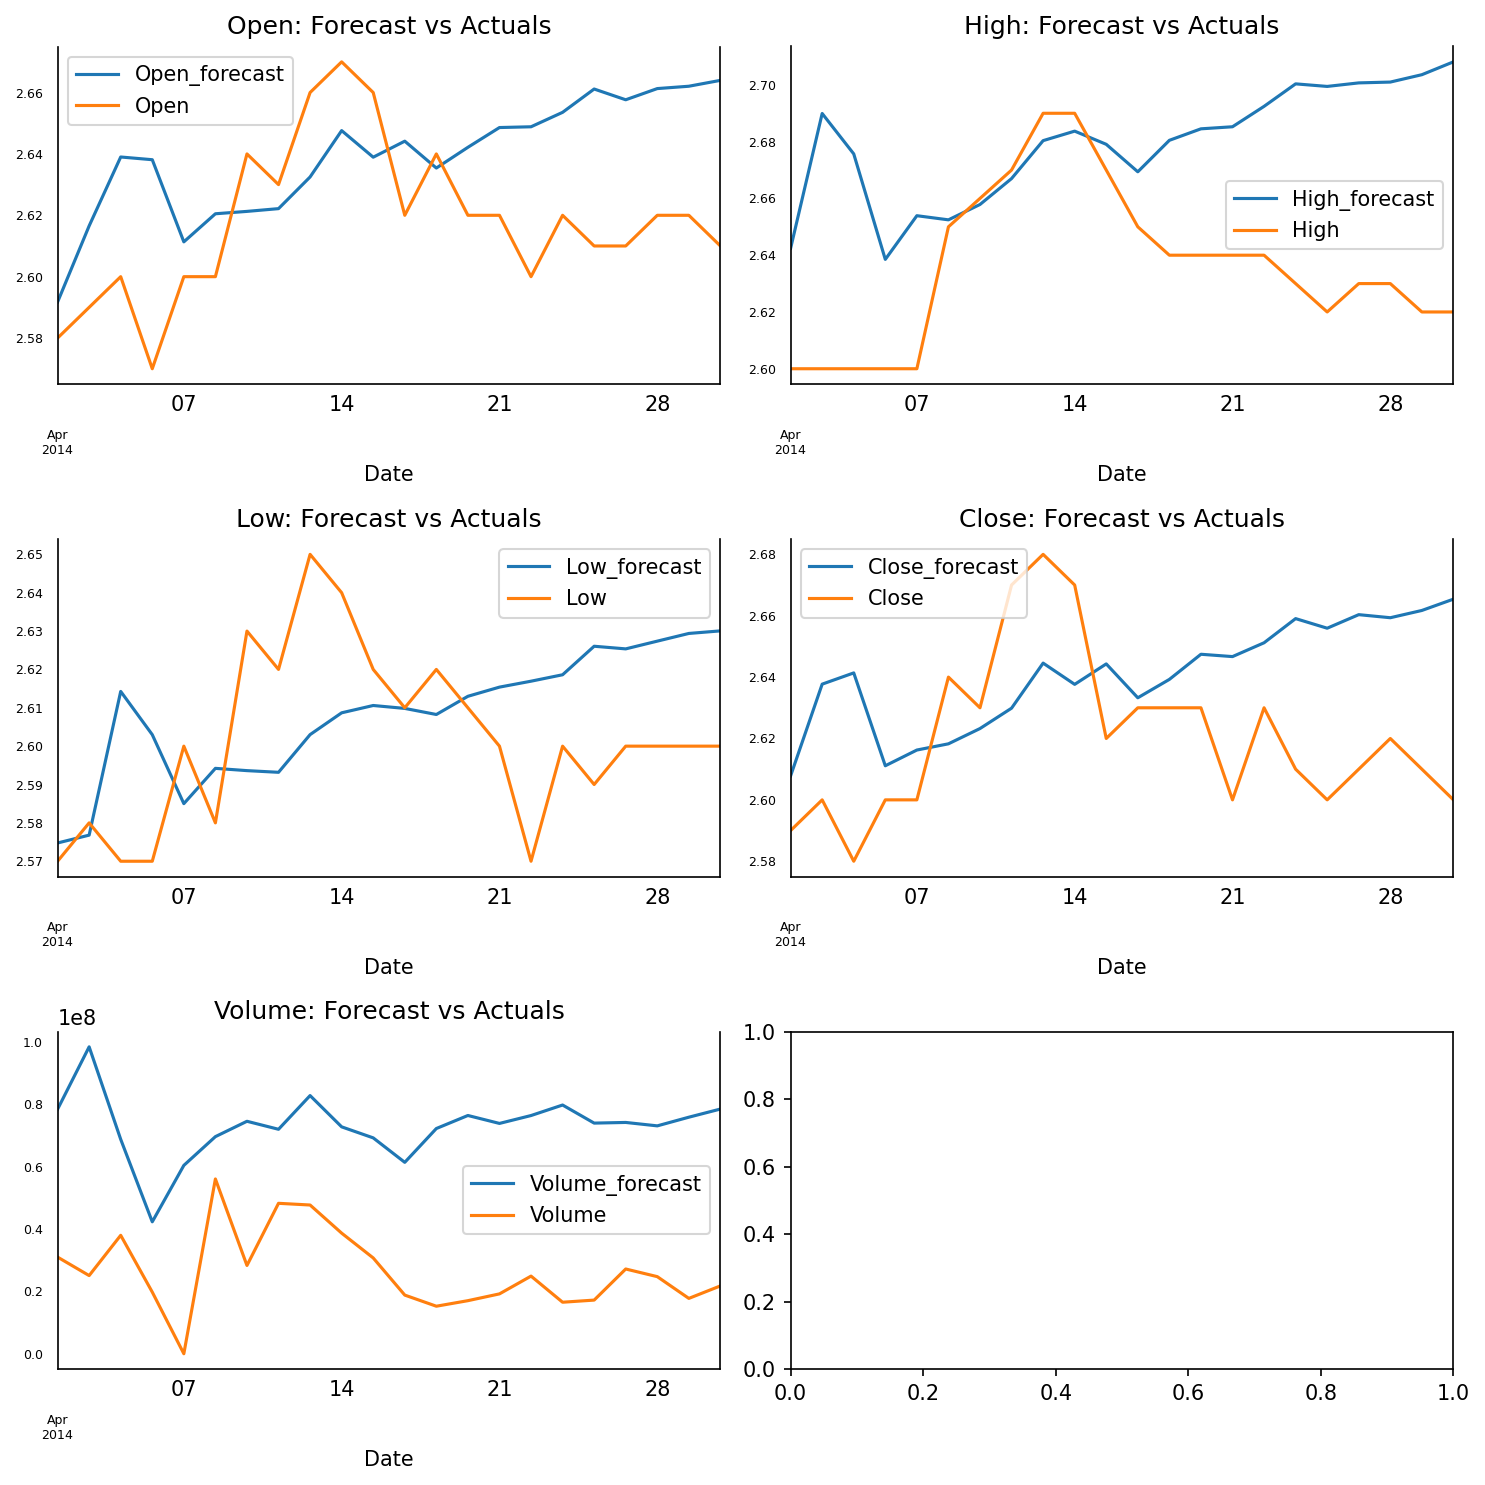

In [24]:
# step11：可视化对比
fig, axes = plt.subplots(nrows=int(len(df.columns)/2)+1, ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout()

In [25]:
# step12：结果检验
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

print('Forecast Accuracy of: Open')
accuracy_prod = forecast_accuracy(df_results['Open_forecast'].values, df_test['Open'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

print('\nForecast Accuracy of: High')
accuracy_prod = forecast_accuracy(df_results['High_forecast'].values, df_test['High'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

print('\nForecast Accuracy of: Low')
accuracy_prod = forecast_accuracy(df_results['Low_forecast'].values, df_test['Low'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

print('\nForecast Accuracy of: Close')
accuracy_prod = forecast_accuracy(df_results['Close_forecast'].values, df_test['Close'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

print('\nForecast Accuracy of: Volume')
accuracy_prod = forecast_accuracy(df_results['Volume_forecast'].values, df_test['Volume'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

Forecast Accuracy of: Open
mape :  0.0117
me :  0.0213
mae :  0.0306
mpe :  0.0082
rmse :  0.0346
corr :  0.2246
minmax :  0.0115

Forecast Accuracy of: High
mape :  0.0173
me :  0.0435
mae :  0.0454
mpe :  0.0166
rmse :  0.0544
corr :  0.0702
minmax :  0.0169

Forecast Accuracy of: Low
mape :  0.0089
me :  0.0067
mae :  0.0232
mpe :  0.0026
rmse :  0.0272
corr :  0.0753
minmax :  0.0088

Forecast Accuracy of: Close
mape :  0.0124
me :  0.0201
mae :  0.0325
mpe :  0.0078
rmse :  0.0372
corr :  -0.0431
minmax :  0.0122

Forecast Accuracy of: Volume
mape :  inf
me :  46443458.9531
mae :  46443458.9531
mpe :  inf
rmse :  48691346.57
corr :  0.1735
minmax :  0.6338
